In [115]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf

## 데이터 불러오기

In [116]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 단어사전 구축

전처리 포함

In [212]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 단어 토큰화
    X_train = []
    for review in train_data['document']:
        tokens = tokenizer.morphs(review)
        X_train.append([token for token in tokens if not token in stopwords])
    X_test = []
    for review in test_data['document']:
        tokens = tokenizer.morphs(review)
        X_test.append([token for token in tokens if not token in stopwords])
    
    # train 문장의 단어를 빈도순으로 정렬하여 사전화 
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = [''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 단어사전에 있는 단어로 변환 및 없는 단어는 비움 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [122]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [123]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [124]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))

<BOS>
드라마 귀신 <BOS> <BOS> 같 씨 없 음 달


keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [133]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [134]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train,value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test,value=word_to_index["<PAD>"],padding='pre',maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 셀프 임베딩

In [165]:
vocab_size = 10000    
word_vector_dim = 16  

embedding = tf.keras.Sequential()
embedding.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
embedding_layer = embedding.layers[0]
weights = embedding_layer.get_weights()[0]

In [166]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = embedding.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [167]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_self = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors_self.similar_by_word("사랑")

[('이집트', 0.7828325629234314),
 ('작위', 0.7780234217643738),
 ('흐믓', 0.7705455422401428),
 ('그려냈', 0.7675185799598694),
 ('놀라', 0.7412804961204529),
 ('어리', 0.7395816445350647),
 ('로드리게즈', 0.7305300235748291),
 ('날아가', 0.7304680347442627),
 ('은데', 0.7279002070426941),
 ('취향', 0.7161001563072205)]

In [168]:
word_vectors_self.similar_by_word("재미")

[('명감독', 0.7592978477478027),
 ('주변', 0.7550829648971558),
 ('소박', 0.7476992011070251),
 ('선장', 0.7334851622581482),
 ('빡', 0.7186636328697205),
 ('예의', 0.7158717513084412),
 ('온갖', 0.7055344581604004),
 ('나누', 0.6987045407295227),
 ('메세지', 0.6986538171768188),
 ('폴', 0.6937643885612488)]

**셀프 임베딩에선 전혀 유사단어를 찾기 힘들었음**

### Word2vec_ko

In [169]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)


In [170]:
vocab_size = 10000    
word_vector_dim = 100 

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [171]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

#### 임베딩 비교분석

확실히 사전 임베딩이 유사 단어를 잘 찾았음

## 모델 훈련

자체 임베딩이 아닌 불러온 임베딩으로 훈련하고, 학습가능하게 하여 임베딩의 변화 확인

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [174]:
X_val = X_train[:10000]   
y_val = y_train[:10000]

partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [175]:
from tensorflow.keras.initializers import Constant

### 모델 1 단순 DNN

결과 : 정확도 54%로 매우 안좋음

In [176]:
model_dnn = tf.keras.Sequential()
model_dnn.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen,trainable=True))   # trainable을 True로 주면 Fine-tuningmodel_dnn.add(tf.keras.layers.Dense(32, activation='relu'))
model_dnn.add(tf.keras.layers.Dense(16, activation='relu'))
model_dnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_dnn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
dense_13 (Dense)             (None, 41, 16)            1616      
_________________________________________________________________
dense_14 (Dense)             (None, 41, 1)             17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


In [179]:
model_dnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_dnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

In [180]:
results = model_dnn.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6743 - accuracy: 0.5461
[0.6742711067199707, 0.5461465716362]


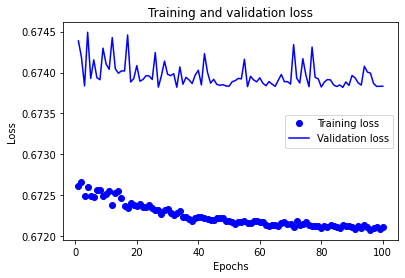

In [181]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 모델 2 LSTM

모델 1이 성능이 낮아 3층의 LSTM으로 시도

결과 : 83.94%로 모델 1 보단 성능이 매우 높지만 루브릭에는 못미침

In [186]:
embedding_matrix.shape[1] / 8


12.5

In [193]:
lstm_size = int(embedding_matrix.shape[1] / 8)

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen,trainable=True))   # trainable을 True로 주면 Fine-tuningmodel_dnn.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.LSTM(lstm_size,return_sequences=True,))   
model_lstm.add(tf.keras.layers.LSTM(lstm_size,return_sequences=True,))   
model_lstm.add(tf.keras.layers.LSTM(lstm_size))   
model_lstm.add(tf.keras.layers.Dense(lstm_size, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_lstm.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 41, 12)            5424      
_________________________________________________________________
lstm_10 (LSTM)               (None, 41, 12)            1200      
_________________________________________________________________
lstm_11 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dense_25 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 13        
Total params: 1,007,993
Trainable params: 1,007,993
Non-trainable params: 0
___________________________________________

In [194]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

In [201]:
results = model_lstm.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4165 - accuracy: 0.8394
[0.4165233373641968, 0.8393921256065369]


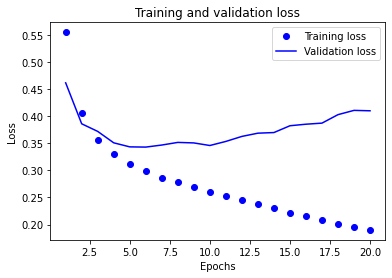

In [196]:
history_dict = history_lstm.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 모델 3 CNN을 활용 (CNN + LSTM)

결과 : 정확도 77.76%로 모델 2보다 성능이 좋지 않음

In [206]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen,trainable=True))
model_cnn.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(2))
model_cnn.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(2))
model_cnn.add(tf.keras.layers.LSTM(lstm_size,return_sequences=True,))   
model_cnn.add(tf.keras.layers.LSTM(lstm_size,return_sequences=True,))   
model_cnn.add(tf.keras.layers.LSTM(lstm_size))   
model_cnn.add(tf.keras.layers.Dense(lstm_size, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_cnn.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 39, 16)            4816      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 17, 32)            1568      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 8, 12)             2160      
_________________________________________________________________
lstm_17 (LSTM)               (None, 8, 12)           

In [207]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

In [208]:
results = model_cnn.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.5393 - accuracy: 0.7776
[0.5392841100692749, 0.7776105403900146]


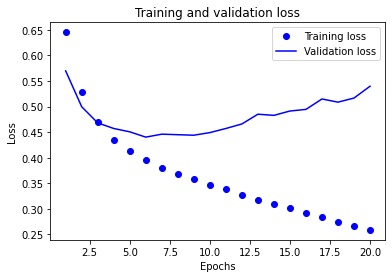

In [209]:
history_dict = history_cnn.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 모델 4 불용어 추가 제거

결과 : 정확도 84.5%로 루브릭에 조금 못미침

#### 단어 사전에서 빈도가 높은 불용어가 몇개 보여서 불용어를 더 제거

구두점(.), 을 등

In [218]:
from konlpy.tag import Mecab

new_stopwords = ['.','을', ',']
stopwords.extend(new_stopwords)

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train,value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test,value=word_to_index["<PAD>"],padding='pre',maxlen=maxlen)

In [219]:
vocab_size = 10000    
word_vector_dim = 100 

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [233]:
X_val = X_train[:10000]   
y_val = y_train[:10000]

partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]



#### 모델

In [224]:
lstm_size = int(embedding_matrix.shape[1] / 8)

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen,trainable=True))   # trainable을 True로 주면 Fine-tuningmodel_dnn.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.LSTM(lstm_size,return_sequences=True,))   
model_lstm.add(tf.keras.layers.LSTM(lstm_size,return_sequences=True,))   
model_lstm.add(tf.keras.layers.LSTM(lstm_size))   
model_lstm.add(tf.keras.layers.Dense(lstm_size, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_lstm.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 38, 100)           1000000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 38, 12)            5424      
_________________________________________________________________
lstm_20 (LSTM)               (None, 38, 12)            1200      
_________________________________________________________________
lstm_21 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dense_31 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 13        
Total params: 1,007,993
Trainable params: 1,007,993
Non-trainable params: 0
___________________________________________

In [234]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=0)

In [237]:
results = model_lstm.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3719 - accuracy: 0.8449
[0.3718808889389038, 0.8448644280433655]


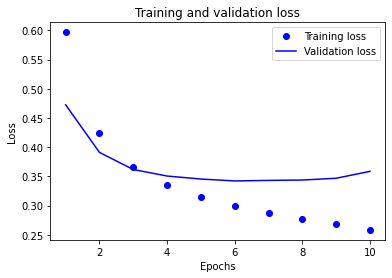

In [238]:
history_dict = history_lstm.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 최종 모델
양방향 lstm을 적용하여 최종 모델 결정  

모델 구조 : in-양방향lstm-양방향lstm-양방향lstm-dense-dense-out  

**최종 정확도 : 85.48%**

* recurrent dropout을 사용하려고 했는데, cudnn이 작동하지 않아 20분동안 돌리다가 포기


In [289]:
lstm_size = int(embedding_matrix.shape[1] / 8)

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen,trainable=True)) 
# 양방향 lstm. dropout 0.2도 적용
model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size,return_sequences=True, dropout=0.2)))  
model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size,return_sequences=True, dropout=0.2)))  
model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size, dropout=0.2)))  

# 모델 복잡성을 위해 dense을 2층 쌓음 
model_lstm.add(tf.keras.layers.Dense(lstm_size, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(int(lstm_size/2), activation='relu'))

model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=0)

results = model_lstm.evaluate(X_test, y_test, verbose=2)

1537/1537 - 8s - loss: 0.3437 - accuracy: 0.8548


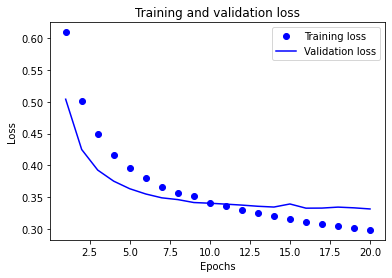

In [290]:
history_dict = history_lstm.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

경향성을 보기 힘들어 epoch를 늘려봄

In [293]:
lstm_size = int(embedding_matrix.shape[1] / 8)

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(
    vocab_size, word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen,trainable=True)) 
model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size,return_sequences=True, dropout=0.2)))  
model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size,return_sequences=True, dropout=0.2)))  
model_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size, dropout=0.2)))  

model_lstm.add(tf.keras.layers.Dense(lstm_size, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(int(lstm_size/2), activation='relu'))

model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=0)

results = model_lstm.evaluate(X_test, y_test, verbose=2)

1537/1537 - 8s - loss: 0.3657 - accuracy: 0.8547


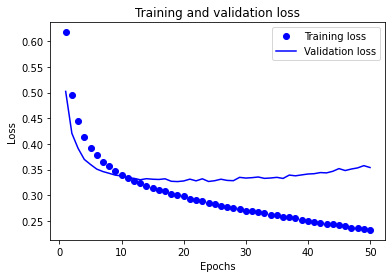

In [294]:
history_dict = history_lstm.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

epoch 20에서의 성능이 괜찮은 것으로 보임

## 결론 및 회고

다양한 시도를 하면서 **양방향 lstm**을 사용하게 되었다.  
최종 정확도는 **85.48%**로 루브릭을 겨우 넘는 수준이어서 아쉬웠다.  

여러 실험을 통해 알게되 점  
 1. lstm 층을 늘리는 것이 성능 향상에 도움을 주기는 하였는데, 계속 늘리는 것은 의미가 없었다.   
 2. nlp에선 양방향 lstm이 일반 lstm보다 성능이 좋은 걸 체감하였다.   
 3. cnn층으로 특성 추출을 하고 lstm층으로 감성분석을 하는 것은 매우매우 성능이 좋지 않았다.  
 4. 구둣점이나 '을' 같이 제거되지 못한 불용어를 추가제거 하여도 성능 향상에 많은 도움을 주지는 않았다.  

마지막에 조원분이 lstm레이어 층을 넓히면 성능이 좋아진다고 하셔서 시도해 봐야 할 것 같다. 

### 추가. 훈련 후 임베딩 비교

임베딩을 훈련가능하게 하여 임베딩이 바뀐것을 보았는데 처음 임베딩보다 안좋아 진 거 같다.

In [ ]:
vocab_size = 10000    
word_vector_dim = 16 

embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/wortxtd2vec.'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = embedding.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
word_vectors_self = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors_self.similar_by_word("사랑")

[('블로그', 0.8074831366539001),
 ('어우러져', 0.7980995178222656),
 ('한지훈', 0.7670777440071106),
 ('뒤통수', 0.7457050681114197),
 ('지겹', 0.7436698079109192),
 ('돋보이', 0.7188777327537537),
 ('통찰', 0.7164884209632874),
 ('애써', 0.7157044410705566),
 ('검색어', 0.7026494741439819),
 ('자리', 0.6938202381134033)]